# Dataset Overview and Project Description

### This problem involves the Carseats data set data set containing sales of child car seats at 400 different stores. A number of characteristics are recorded:

* Sales: Unit sales (in thousands) at each location
* CompPrice: Price charged by competitor at each location
* Income: Community income level (in thousands of dollars)
* Advertising: Local advertising budget for company at each location (in thousands of dollars)
* Population: Population size in region (in thousands)
* Price: Price company charges for car seats at each site
* ShelveLoc: A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
* Age: Average age of the local population
* Education: Education level at each location
* Urban: A factor with levels No and Yes to indicate whether the store is in an urban or rural location
* US: A factor with levels No and Yes to indicate whether the store is in the US or not


### Please build a model to understand the determination of sales using the first 300 observations.


# Libraries, Ignore Some Warnings, and Data

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
import numpy as np
import pandas as pd
from ISLP import load_data

Carseats = load_data('Carseats')
data = Carseats.head(300)

data.info() # data.shape[0] for number of rows, data.shape[1] for number of columns
numeric_data = data.select_dtypes(include=['int64','float64'])
categorical_data = data.select_dtypes(include='category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        300 non-null    float64 
 1   CompPrice    300 non-null    int64   
 2   Income       300 non-null    int64   
 3   Advertising  300 non-null    int64   
 4   Population   300 non-null    int64   
 5   Price        300 non-null    int64   
 6   ShelveLoc    300 non-null    category
 7   Age          300 non-null    int64   
 8   Education    300 non-null    int64   
 9   Urban        300 non-null    category
 10  US           300 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 20.1 KB


In [19]:
print("Duplicates in numeric data:", numeric_data.duplicated().sum())
print("\nNumber of nulls for each column:\n",data.isnull().sum())
print("\nNumber of infinite values for each column:\n\n",np.isinf(numeric_data).sum())

Duplicates in numeric data: 0

Number of nulls for each column:
 Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

Number of infinite values for each column:

 Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
Age            0
Education      0
dtype: int64


In [20]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales,300.0,7.362967,2.835229,0.0,5.255,7.445,9.11,14.9
CompPrice,300.0,124.536667,15.343840,77.0,115.000,123.500,135.00,162.0
Income,300.0,69.843333,27.716291,21.0,44.750,70.500,91.25,120.0
Advertising,300.0,6.036667,6.262538,0.0,0.000,5.000,11.00,25.0
Population,300.0,260.716667,147.445959,10.0,136.250,265.500,391.50,509.0
Price,300.0,115.490000,23.655199,24.0,99.750,117.000,131.00,191.0
Age,300.0,53.743333,16.298761,25.0,39.750,55.500,66.00,80.0
Education,300.0,14.020000,2.702581,10.0,12.000,14.000,16.25,18.0


# Visualizing Target Variable (Sales)

Text(0, 0.5, 'Frequency')

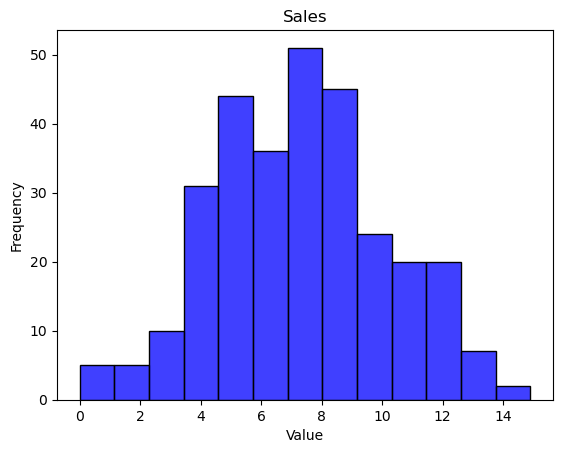

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.histplot(data['Sales'],color='blue')
plt.title(f"{'Sales'}")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Visualizing Categorical Variables

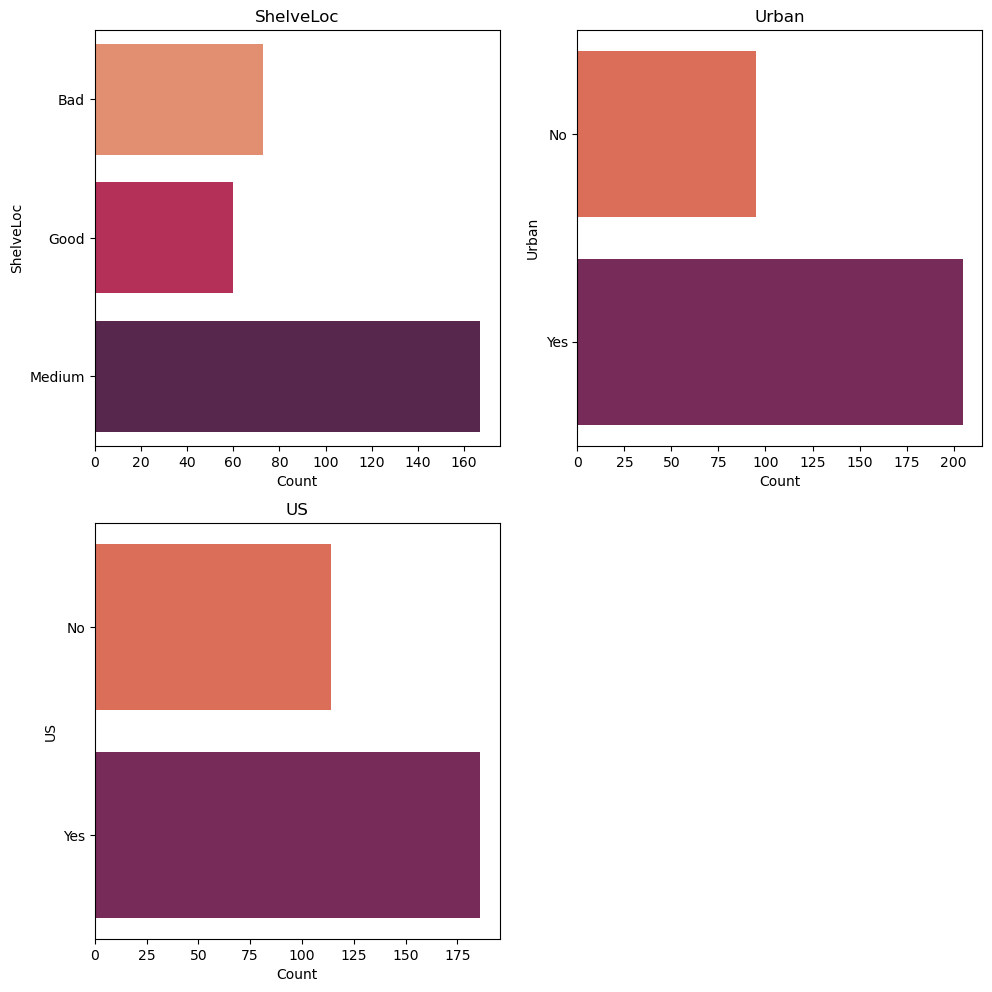

In [22]:
plt.figure(figsize=(10,10))
for i, feature in enumerate(categorical_data.columns):
    counts = data[feature].value_counts().head(10)
    plt.subplot(2, 2, i+1)
    sns.barplot(x=counts.values, y=counts.index, palette='rocket_r')
    plt.title(f"{feature}")
    plt.xlabel("Count")
plt.tight_layout(pad=1.0)
#plt.savefig("categorical_features_plots.png"); plt.clf();

# Visualizing Numeric Features/Inputs

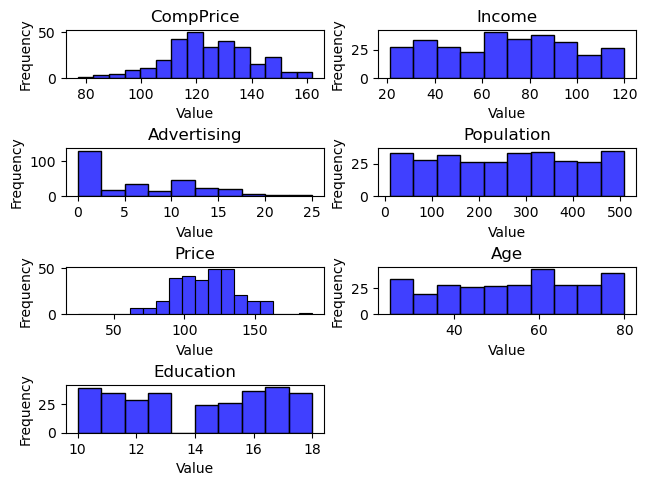

In [23]:
for i, feature in enumerate(numeric_data.columns[1:]): # Sales is first column, so it is excluded since it is target variable
    plt.subplot(4,2,i+1) # rows (first param) * cols (second param) = 8 
    sns.histplot(data[feature],color='blue')
    plt.title(f"{feature}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
plt.tight_layout(pad=0.5)
#plt.savefig("continuous_features_plots.png"); plt.clf()

# Data Pre-Processing

1. Scale numeric features with RobustScaler (robust to outliers by scaling with 25th-75th percentiles of dataset)

2. Encode categorical variables with OneHotEncoder

* 1 and 2 are combined in ColumnTransformer (alternative could be using Pipeline object storing all preprocessing)

3. Split into training and testing

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline

X = data.drop('Sales',axis=1)
y = data['Sales']

numeric_features = ['CompPrice', 'Income', 'Advertising', 'Population','Price', 'Age', 'Education']
categorical_features = ['ShelveLoc', 'Urban', 'US']

preprocessor = ColumnTransformer(transformers = [('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features) ])

X = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Models (Uses K-Fold Cross-Validation With K = 5)

### 1. Train model with GridSearchCV
### 2. Predict testing data with best model from step 1
### 3. Metrics: R-squared for all, Correlation Matrix in Regression, Feature Importance in Ensembles

### Linear Regression

In [25]:
import sklearn.model_selection as skm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

kfold = skm.KFold(5, random_state=42, shuffle=True)

linear_grid = skm.GridSearchCV(
        LinearRegression(),
        {}, # no hyperparameter tuning
        refit=True,
        cv=kfold,
        scoring='accuracy')

linear_grid.fit(X_train,y_train)
best_linear = linear_grid.best_estimator_

y_pred_train = best_linear.predict(X_train)
y_pred_test = best_linear.predict(X_test)

coefficients_rounded = [f'{num:.4f}' for num in best_linear.coef_]

print(f"Intercept: {best_linear.intercept_:.4f}\nCoefficients: {coefficients_rounded}")
print(f"Training R-Squared: {r2_score(y_train,y_pred_train):.4f}")

print(f'Testing R-Squared: {r2_score(y_test, y_pred_test):.4f}')

Intercept: 7.1272
Coefficients: ['1.9296', '0.7849', '1.6044', '0.0029', '-2.9583', '-1.1465', '-0.1119', '-2.1860', '2.5370', '-0.3509', '-0.0544', '0.0544', '0.2406', '-0.2406']
Training R-Squared: 0.8786
Testing R-Squared: 0.8887


### Ridge Regression With Parameter Tuning

#### For Ridge and LASSO, alpha would not work in param_grid in GridSearchCV, so for loop was implemented

In [26]:
columns = ['Model','Intercept','Training R-Squared','Testing R-Squared','Coefficients']
ridge_models = pd.DataFrame(index=[0,1,2],columns=columns)
ridge_models.loc[0,'Model'] = Ridge(alpha=5)
ridge_models.loc[1,'Model'] = Ridge(alpha=1)
ridge_models.loc[2,'Model'] = Ridge(alpha=0.1)

for i in ridge_models.index:
    ridge_grid = skm.GridSearchCV(
        ridge_models.loc[i,'Model'],
        {}, # no hyperparameter tuning in grid search cv
        refit=True,
        cv=kfold,
        scoring='accuracy')

    ridge_grid.fit(X_train,y_train)
    best_ridge = ridge_grid.best_estimator_

    y_pred_train = best_ridge.predict(X_train)
    y_pred_test = best_ridge.predict(X_test)

    ridge_models.loc[i,'Intercept'] = f'{best_ridge.intercept_:.4f}'
    ridge_models.loc[i,'Coefficients'] = [f'{num:.4f}' for num in best_ridge.coef_]
    ridge_models.loc[i,'Training R-Squared'] = f'{r2_score(y_train,y_pred_train):.4f}'
    ridge_models.loc[i,'Testing R-Squared'] = f'{r2_score(y_test, y_pred_test):.4f}'

ridge_models

,Model,Intercept,Training R-Squared,Testing R-Squared,Coefficients
0,Ridge(alpha=5),7.1281,0.8725,0.8805,"[1.7514, 0.7374, 1.3991, -0.0079, -2.7286, -1...."
1,Ridge(alpha=1),7.1272,0.8783,0.8881,"[1.8911, 0.7748, 1.5573, 0.0008, -2.9091, -1.1..."
2,Ridge(alpha=0.1),7.1272,0.8786,0.8887,"[1.9257, 0.7839, 1.5995, 0.0027, -2.9533, -1.1..."


### LASSO Regression With Parameter Tuning

In [27]:
columns = ['Model','Intercept','Training R-Squared','Testing R-Squared','Coefficients']
lasso_models = pd.DataFrame(index=[0,1,2],columns=columns)
lasso_models.loc[0,'Model'] = Lasso(alpha=0.1)
lasso_models.loc[1,'Model'] = Lasso(alpha=0.01)
lasso_models.loc[2,'Model'] = Lasso(alpha=0.0001)

for i in lasso_models.index:
    lasso_grid = skm.GridSearchCV(
        lasso_models.loc[i,'Model'],
        {}, # no hyperparameter tuning in grid search cv
        refit=True,
        cv=kfold,
        scoring='accuracy')

    lasso_grid.fit(X_train,y_train)
    best_lasso = lasso_grid.best_estimator_

    y_pred_train = best_lasso.predict(X_train)
    y_pred_test = best_lasso.predict(X_test)

    lasso_models.loc[i,'Intercept'] = f'{best_lasso.intercept_:.4f}'
    lasso_models.loc[i,'Coefficients'] = [f'{num:.4f}' for num in best_lasso.coef_]
    lasso_models.loc[i,'Training R-Squared'] = f'{r2_score(y_train,y_pred_train):.4f}'
    lasso_models.loc[i,'Testing R-Squared'] = f'{r2_score(y_test, y_pred_test):.4f}'

lasso_models

,Model,Intercept,Training R-Squared,Testing R-Squared,Coefficients
0,Lasso(alpha=0.1),6.8200,0.8411,0.8582,"[1.5302, 0.5154, 0.9997, 0.0000, -2.4998, -0.8..."
1,Lasso(alpha=0.01),6.6507,0.8779,0.8898,"[1.8878, 0.7572, 1.4796, 0.0000, -2.9160, -1.1..."
2,Lasso(alpha=0.0001),6.6916,0.8786,0.8887,"[1.9292, 0.7846, 1.6031, 0.0027, -2.9579, -1.1..."


### Correlation Matrix

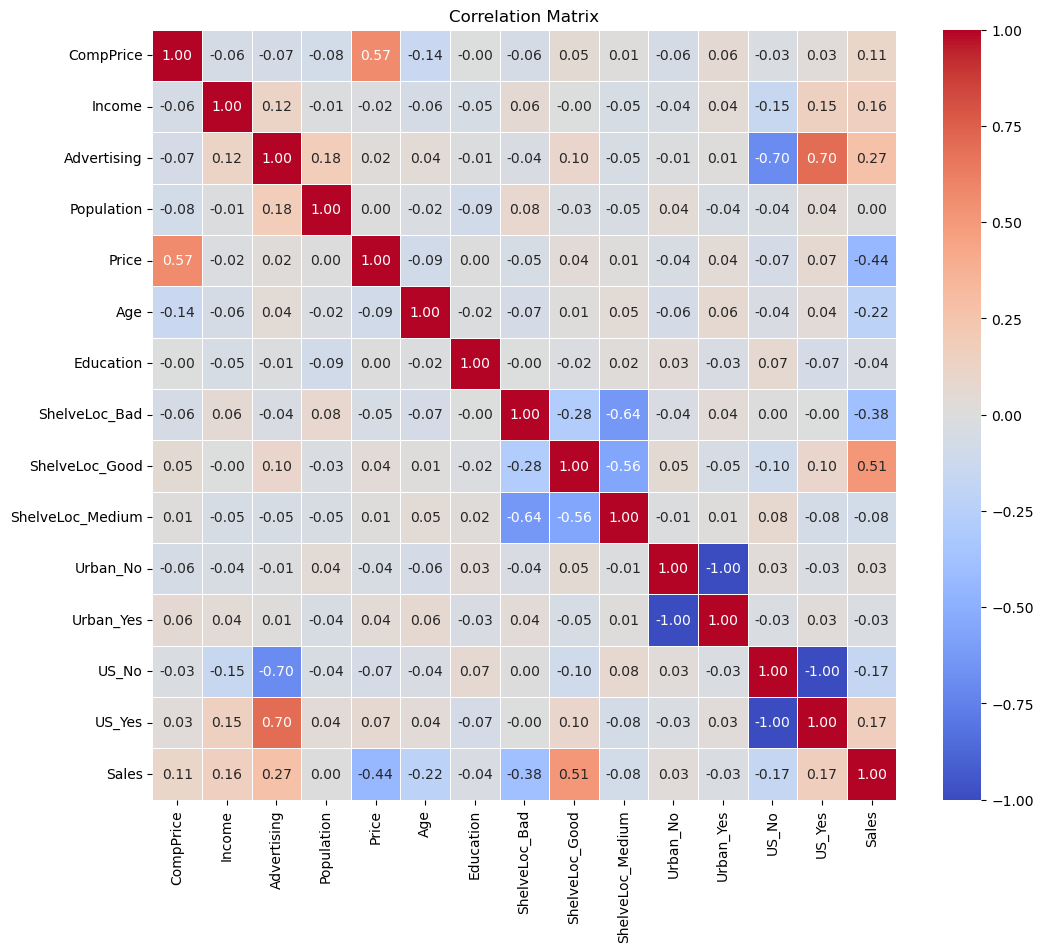

In [28]:
encoded_categories = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
column_names = numeric_features + list(encoded_categories)
transformed_df = pd.DataFrame(X, columns=column_names)
transformed_df['Sales'] = y.reset_index(drop=True)

plt.figure(figsize=(12, 10))
sns.heatmap(transformed_df.corr(), annot=True, fmt=".2f", linewidths=0.5, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Random Forest With Parameter Tuning

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf_grid = skm.GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid={
            'ccp_alpha': [0.01,0.1,10],
            'max_features': [3,5,None],
            'min_samples_split': [5,10,50]
        },
        refit=True,
        cv=kfold,
        scoring='accuracy')

rf_grid.fit(X_train,y_train)
best_rf = rf_grid.best_estimator_

y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

print(f"Best parameters after tuning/cv: {rf_grid.best_params_}")
print(f"Training R-Squared: {r2_score(y_train,y_pred_train):.4f}")

print(f'Testing R-Squared: {r2_score(y_test, y_pred_test):.4f}')

feature_importances = best_rf.feature_importances_
features = transformed_df.drop('Sales',axis=1).columns

pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

Best parameters after tuning/cv: {'ccp_alpha': 0.01, 'max_features': 3, 'min_samples_split': 5}
Training R-Squared: 0.8751
Testing R-Squared: 0.6346


,Feature,Importance
4,Price,0.205083
8,ShelveLoc_Good,0.173927
5,Age,0.095422
1,Income,0.092040
0,CompPrice,0.089748
2,Advertising,0.084315
7,ShelveLoc_Bad,0.075530
3,Population,0.069298
6,Education,0.041614
9,ShelveLoc_Medium,0.033297


### XGBoost With Parameter Tuning

In [30]:
import xgboost as xgb

xgb_grid = skm.GridSearchCV(
    xgb.XGBRegressor(),
    param_grid={
        'max_features': [3,5,None],
        'min_samples_split': [5,10,50]
    },
    refit=True,
    cv=kfold,
    scoring='accuracy')

xgb_grid.fit(X_train,y_train)
best_xgb = xgb_grid.best_estimator_

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print(f"Best parameters after tuning/cv: {xgb_grid.best_params_}")
print(f"Training R-Squared: {r2_score(y_train,y_pred_train):.4f}")

print(f'Testing R-Squared: {r2_score(y_test, y_pred_test):.4f}')

feature_importances = best_xgb.feature_importances_
features = transformed_df.drop('Sales',axis=1).columns

pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

Best parameters after tuning/cv: {'max_features': 3, 'min_samples_split': 5}
Training R-Squared: 1.0000
Testing R-Squared: 0.7026


,Feature,Importance
8,ShelveLoc_Good,0.743838
7,ShelveLoc_Bad,0.114637
4,Price,0.056540
2,Advertising,0.021581
5,Age,0.021372
0,CompPrice,0.015734
1,Income,0.010088
6,Education,0.005808
10,Urban_No,0.004618
3,Population,0.003483
